# Kolmogorov-Arnold State-Space Model

Combining Kolmogorov-Arnold Networks (KANs) with state-space models to improve extrapolation performance is an innovative approach that leverages the strengths of both methodologies. This involves creating a hybrid architecture that combines KANs and state-space models, where the state-space model captures the temporal dynamics and the KAN handles the function approximation.

**State-Space Model (SSM)**: Use a state-space model to describe the evolution of the system's state over time. The state-space model typically consists of:

$$
\begin{aligned}
&x_{t+1} = A x_t + B u_t + w_t \\
&y_t = C x_t + D u_t + v_t  
\end{aligned}
$$

where $x_t$ is the state vector, $u_t$ is the input vector, $y_t$ is the output vector, and $w_t$ and $v_t$ are noise terms.

**KAN Integration**: Integrate a KAN to approximate the nonlinear functions involved in the state transition or the observation equations. For example, the state transition equation could be modified as:

$$
x_{t+1} = \sum_{i=1}^{2n+1} \phi_i \left( \sum_{j=1}^n \psi_{ij}(x_t, u_t) \right) + w_t
$$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# NN implementation
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(NN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim

        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# KAN layer  
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# State-Space Model Implementation
class StateSpaceModel(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kan_layers):
        super(StateSpaceModel, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define the KANs for state transition and observation
        self.kan_state_transition = KAN([state_dim + input_dim] + kan_layers + [state_dim])
        self.kan_observation = KAN([state_dim + input_dim] + kan_layers + [output_dim])

    def forward(self, state, input, update_grid=False):
        # State transition: x_{t+1} = f(x_t, u_t)
        state_input = torch.cat([state, input], dim=-1)
        next_state = self.kan_state_transition(state_input, update_grid=update_grid)

        # Observation: y_t = g(x_t, u_t)
        observation = self.kan_observation(state_input, update_grid=update_grid)

        return next_state, observation

# Example Usage
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [16, 16]

model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)

# Example data
batch_size = 1
state = torch.randn(batch_size, state_dim)
input = torch.randn(batch_size, input_dim)
observation_target = torch.randn(batch_size, output_dim)

from torchinfo import summary
print(summary(model, input_data=[state, input]))

# Forward pass
next_state, observation = model(state, input)

# loss
criterion = nn.MSELoss()
loss = criterion(next_state, state) + criterion(observation, observation_target)

print("Next State:", next_state)
print("Observation:", observation)
print("Loss:", loss.item())

Layer (type:depth-idx)                   Output Shape              Param #
StateSpaceModel                          [1, 1]                    --
├─KAN: 1-1                               [1, 1]                    --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [1, 16]                   320
│    │    └─KANLinear: 3-2               [1, 16]                   2,560
│    │    └─KANLinear: 3-3               [1, 1]                    160
├─KAN: 1-2                               [1, 1]                    --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [1, 16]                   320
│    │    └─KANLinear: 3-5               [1, 16]                   2,560
│    │    └─KANLinear: 3-6               [1, 1]                    160
Total params: 6,080
Trainable params: 6,080
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB):

# Harmonic Oscillator

Train Seq Length 30, Extrapolation Length 90, Epoch 10, Train Loss: 3.725e-01, Test Loss: 1.626e-01, Extrapolation Loss: 6.478e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 20, Train Loss: 3.353e-01, Test Loss: 1.446e-01, Extrapolation Loss: 5.940e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 30, Train Loss: 2.857e-01, Test Loss: 1.203e-01, Extrapolation Loss: 5.106e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 40, Train Loss: 2.187e-01, Test Loss: 8.783e-02, Extrapolation Loss: 3.880e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 50, Train Loss: 1.382e-01, Test Loss: 5.103e-02, Extrapolation Loss: 2.494e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 60, Train Loss: 6.653e-02, Test Loss: 2.392e-02, Extrapolation Loss: 2.131e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 70, Train Loss: 3.365e-02, Test Loss: 1.800e-02, Extrapolation Loss: 2.917e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 80, Train Loss: 2.874e-02, Test

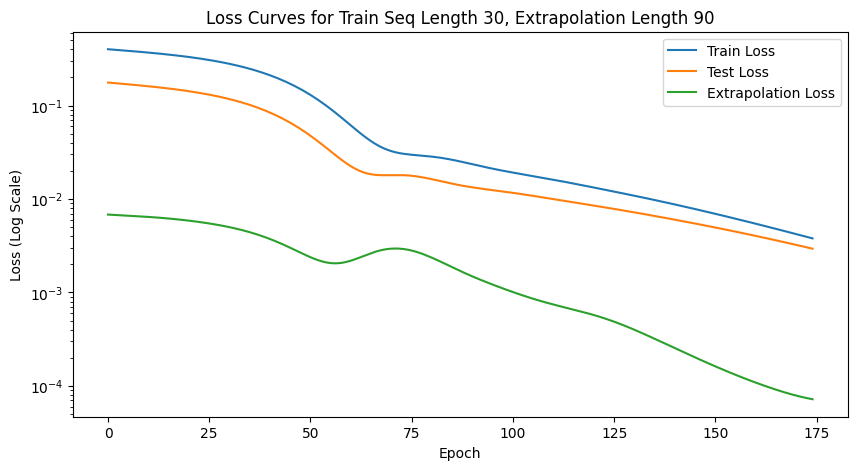

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x  = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length/100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [16, 16]
batch_size = 10
num_sequences = 10
total_seq_length = 120
train_seq_lengths = [30]  # Different lengths of training sequences

convergence_std_threshold = 1e-2  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100
d, w0 = 4, 40

# Initialize performance data dictionary
performance_data = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for train_seq_length in train_seq_lengths:
    extrapolation_length = total_seq_length - train_seq_length
    
    model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)
    # model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    train_data, train_times = generate_oscillator_data(total_seq_length, num_sequences, d, w0)
    # train_data, train_times = train_data.to(device), train_times.to(device)
    
    # Split into train and test sets
    train_size = int(num_sequences)

    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        input = input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        next_state, observation = model(state, input)
        loss = criterion(next_state, state) + criterion(observation, observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            test_state = train_data[:, :train_seq_length-1, :]
            test_input = train_data[:, 1:train_seq_length, :]
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            extrap_state = train_data[:, train_seq_length-1:-1, :]  # Extrapolation part of the sequence
            extrap_input = train_data[:, train_seq_length:, :]  # Extrapolation part of the sequence (next state)
            extrap_target = train_data[:, train_seq_length:, :]  # Extrapolation target is the next value
            
            extrap_state = extrap_state.reshape(-1, state_dim)
            extrap_input = extrap_input.reshape(-1, input_dim)
            extrap_target = extrap_target.reshape(-1, output_dim)
            
            _, extrap_observation = model(extrap_state, extrap_input)
            
            test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, output_dim))
            extrapolation_loss = criterion(extrap_observation, extrap_target)
            test_losses.append((test_loss.item(), extrapolation_loss.item()))

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "extrapolation_length": extrapolation_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1][0],
        "final_extrapolation_loss": test_losses[-1][1]
    })
    
    # Plot loss curves
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses[:, 0], label="Test Loss")
    plt.plot(test_losses[:, 1], label="Extrapolation Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()
    
    # Plot exemplar training data
    exemplar_index = 0
    exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
    exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
    exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

    # Get the model prediction for the extrapolation regime
    model.eval()
    with torch.no_grad():
        extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
        extrap_input = train_data[exemplar_index, train_seq_length:, :]
        
        extrap_state = extrap_state.reshape(-1, state_dim)
        extrap_input = extrap_input.reshape(-1, input_dim)
        
        _, extrap_prediction = model(extrap_state.to(device), extrap_input.to(device))
        extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

    plt.figure(figsize=(12, 6))
    plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
    plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
    plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
    plt.plot(range(train_seq_length, total_seq_length), exemplar_extrapolation, label="Extrapolation Target", color='orange')
    plt.plot(range(train_seq_length, total_seq_length), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
    plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

# Plot a seaborn barplot of the final train, test, and extrapolation losses
plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Train Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Extrapolation Loss (Log Scale)")
plt.legend(title="Extrapolation Length")
plt.show()

# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
    print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


# reformatting

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# NN implementation
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(NN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim

        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# KAN layer  
class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# State-Space Model Implementation
class StateSpaceModel(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kan_layers):
        super(StateSpaceModel, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define the KANs for state transition and observation
        self.kan_state_transition = KAN([state_dim + input_dim] + kan_layers + [state_dim])
        self.kan_observation = KAN([state_dim + input_dim] + kan_layers + [output_dim])

    def forward(self, state, input, update_grid=False):
        # State transition: x_{t+1} = f(x_t, u_t)
        state_input = torch.cat([state, input], dim=-1)
        next_state = self.kan_state_transition(state_input, update_grid=update_grid)

        # Observation: y_t = g(x_t, u_t)
        observation = self.kan_observation(state_input, update_grid=update_grid)

        return next_state, observation

# Example Usage
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [16, 16]

model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers)

# Example data
batch_size = 1
state = torch.randn(batch_size, state_dim)
input = torch.randn(batch_size, input_dim)
observation_target = torch.randn(batch_size, output_dim)

from torchinfo import summary
print(summary(model, input_data=[state, input]))

# Forward pass
next_state, observation = model(state, input)

# loss
criterion = nn.MSELoss()
loss = criterion(next_state, state) + criterion(observation, observation_target)

print("Next State:", next_state)
print("Observation:", observation)
print("Loss:", loss.item())

Layer (type:depth-idx)                   Output Shape              Param #
StateSpaceModel                          [1, 1]                    --
├─KAN: 1-1                               [1, 1]                    --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [1, 16]                   320
│    │    └─KANLinear: 3-2               [1, 16]                   2,560
│    │    └─KANLinear: 3-3               [1, 1]                    160
├─KAN: 1-2                               [1, 1]                    --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [1, 16]                   320
│    │    └─KANLinear: 3-5               [1, 16]                   2,560
│    │    └─KANLinear: 3-6               [1, 1]                    160
Total params: 6,080
Trainable params: 6,080
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB):

Train Seq Length 30, Epoch 10, Train Loss: 2.081e-01, Test Loss: 2.666e-03
Train Seq Length 30, Epoch 20, Train Loss: 8.420e-02, Test Loss: 7.726e-04
Train Seq Length 30, Epoch 30, Train Loss: 9.337e-03, Test Loss: 3.262e-03
Train Seq Length 30, Epoch 40, Train Loss: 1.272e-02, Test Loss: 1.821e-03
Train Seq Length 30, Epoch 50, Train Loss: 2.493e-03, Test Loss: 3.254e-03
Train Seq Length 30, Epoch 60, Train Loss: 2.172e-03, Test Loss: 1.028e-02
Train Seq Length 30, Epoch 70, Train Loss: 8.880e-04, Test Loss: 1.534e-02
Train Seq Length 30, Epoch 80, Train Loss: 8.519e-04, Test Loss: 1.871e-02
Train Seq Length 30, Epoch 90, Train Loss: 6.181e-04, Test Loss: 1.916e-02
Train Seq Length 30, Epoch 100, Train Loss: 5.358e-04, Test Loss: 1.829e-02
Train Seq Length 30, Epoch 110, Train Loss: 4.348e-04, Test Loss: 1.721e-02
Train Seq Length 30, Epoch 120, Train Loss: 3.631e-04, Test Loss: 1.597e-02
Train Seq Length 30, Epoch 130, Train Loss: 3.011e-04, Test Loss: 1.474e-02
Train Seq Length 30, 

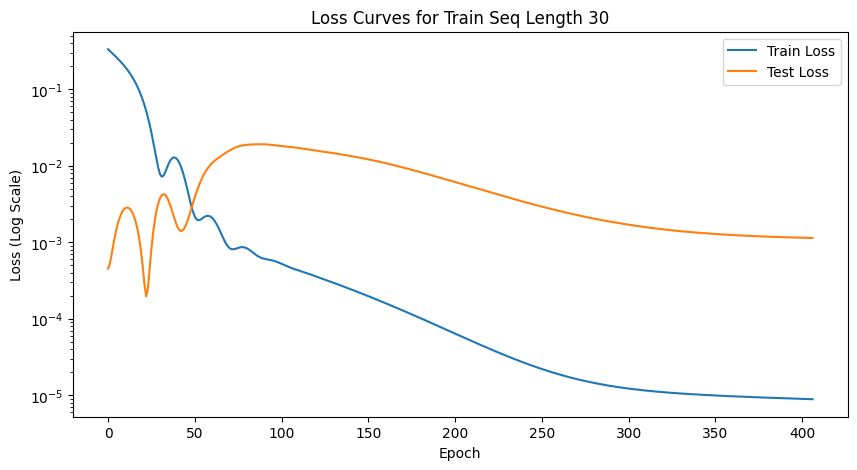

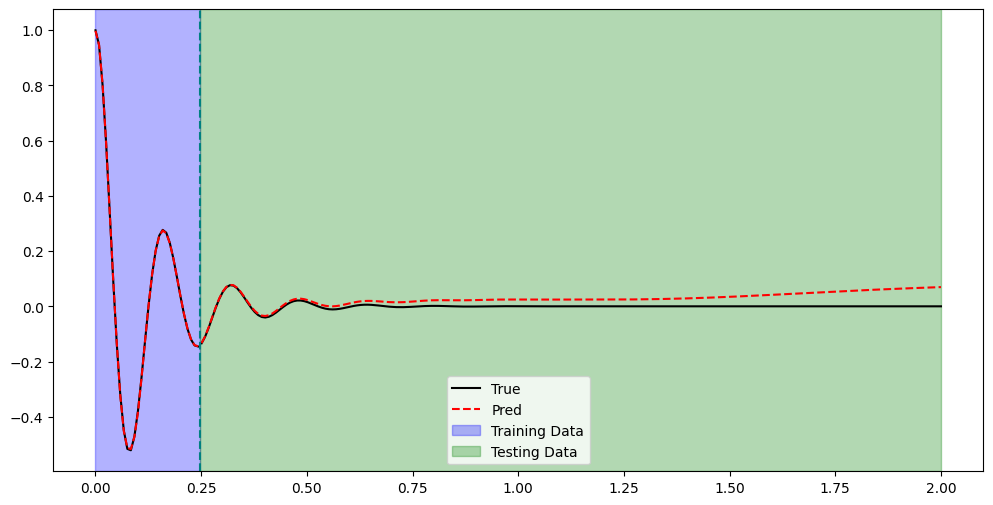

Train Seq Length 60, Epoch 10, Train Loss: 1.004e-01, Test Loss: 2.845e-03
Train Seq Length 60, Epoch 20, Train Loss: 3.937e-02, Test Loss: 3.039e-02
Train Seq Length 60, Epoch 30, Train Loss: 4.545e-03, Test Loss: 4.381e-02
Train Seq Length 60, Epoch 40, Train Loss: 5.244e-03, Test Loss: 7.070e-03
Train Seq Length 60, Epoch 50, Train Loss: 1.124e-03, Test Loss: 2.542e-03
Train Seq Length 60, Epoch 60, Train Loss: 1.206e-03, Test Loss: 1.582e-03
Train Seq Length 60, Epoch 70, Train Loss: 5.067e-04, Test Loss: 2.333e-03
Train Seq Length 60, Epoch 80, Train Loss: 4.448e-04, Test Loss: 7.096e-03
Train Seq Length 60, Epoch 90, Train Loss: 3.124e-04, Test Loss: 7.971e-03
Train Seq Length 60, Epoch 100, Train Loss: 2.573e-04, Test Loss: 7.618e-03
Train Seq Length 60, Epoch 110, Train Loss: 2.015e-04, Test Loss: 8.342e-03
Train Seq Length 60, Epoch 120, Train Loss: 1.594e-04, Test Loss: 9.672e-03
Train Seq Length 60, Epoch 130, Train Loss: 1.250e-04, Test Loss: 1.093e-02
Train Seq Length 60, 

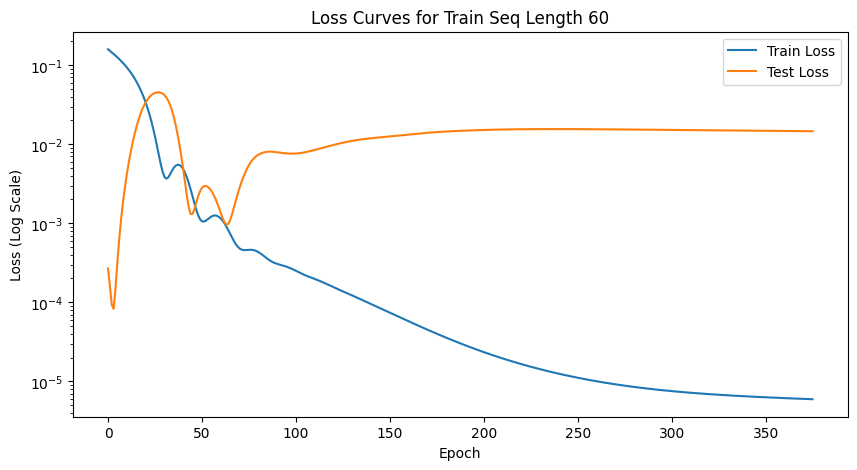

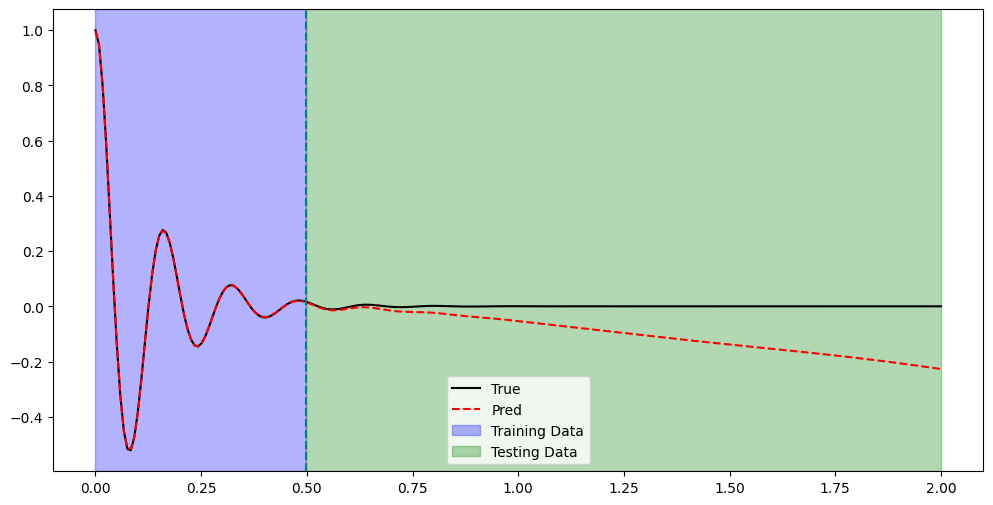

Train Seq Length 90, Epoch 10, Train Loss: 6.759e-02, Test Loss: 2.805e-05
Train Seq Length 90, Epoch 20, Train Loss: 2.648e-02, Test Loss: 4.415e-04
Train Seq Length 90, Epoch 30, Train Loss: 3.501e-03, Test Loss: 2.871e-03
Train Seq Length 90, Epoch 40, Train Loss: 3.607e-03, Test Loss: 1.851e-02
Train Seq Length 90, Epoch 50, Train Loss: 8.277e-04, Test Loss: 2.133e-03
Train Seq Length 90, Epoch 60, Train Loss: 6.807e-04, Test Loss: 3.897e-04
Train Seq Length 90, Epoch 70, Train Loss: 3.379e-04, Test Loss: 4.814e-04
Train Seq Length 90, Epoch 80, Train Loss: 2.960e-04, Test Loss: 6.615e-04
Train Seq Length 90, Epoch 90, Train Loss: 2.223e-04, Test Loss: 5.177e-04
Train Seq Length 90, Epoch 100, Train Loss: 1.843e-04, Test Loss: 4.303e-04
Train Seq Length 90, Epoch 110, Train Loss: 1.473e-04, Test Loss: 5.190e-04
Train Seq Length 90, Epoch 120, Train Loss: 1.193e-04, Test Loss: 7.683e-04
Train Seq Length 90, Epoch 130, Train Loss: 9.543e-05, Test Loss: 1.010e-03
Train Seq Length 90, 

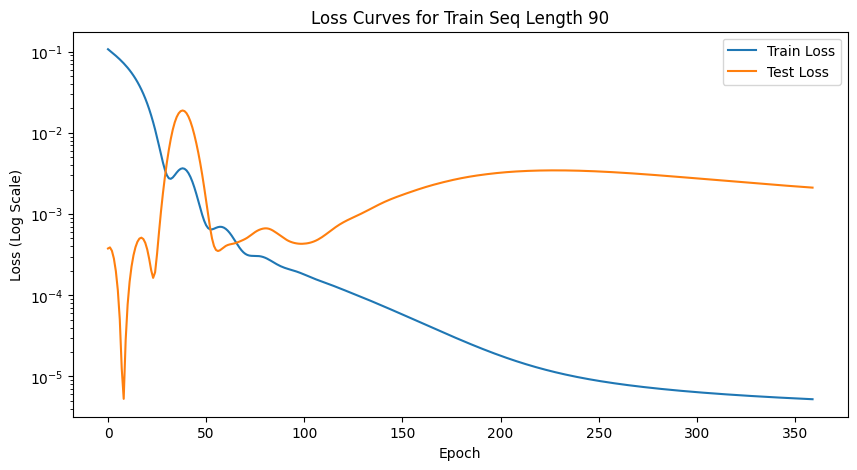

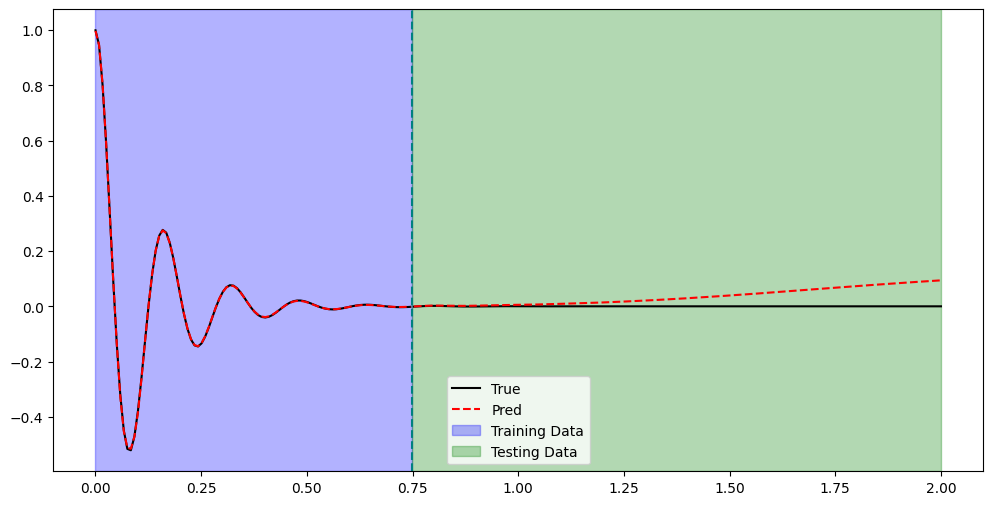

Train Seq Length 120, Epoch 10, Train Loss: 4.945e-02, Test Loss: 6.539e-05
Train Seq Length 120, Epoch 20, Train Loss: 2.093e-02, Test Loss: 5.029e-04
Train Seq Length 120, Epoch 30, Train Loss: 3.786e-03, Test Loss: 2.822e-03
Train Seq Length 120, Epoch 40, Train Loss: 3.193e-03, Test Loss: 1.372e-03
Train Seq Length 120, Epoch 50, Train Loss: 9.302e-04, Test Loss: 3.360e-04
Train Seq Length 120, Epoch 60, Train Loss: 6.574e-04, Test Loss: 5.542e-04
Train Seq Length 120, Epoch 70, Train Loss: 3.613e-04, Test Loss: 2.143e-04
Train Seq Length 120, Epoch 80, Train Loss: 2.664e-04, Test Loss: 1.130e-04
Train Seq Length 120, Epoch 90, Train Loss: 1.810e-04, Test Loss: 5.529e-04
Train Seq Length 120, Epoch 100, Train Loss: 1.480e-04, Test Loss: 1.001e-03
Train Seq Length 120, Epoch 110, Train Loss: 1.182e-04, Test Loss: 1.239e-03
Train Seq Length 120, Epoch 120, Train Loss: 9.622e-05, Test Loss: 1.164e-03
Train Seq Length 120, Epoch 130, Train Loss: 7.744e-05, Test Loss: 9.812e-04
Train Se

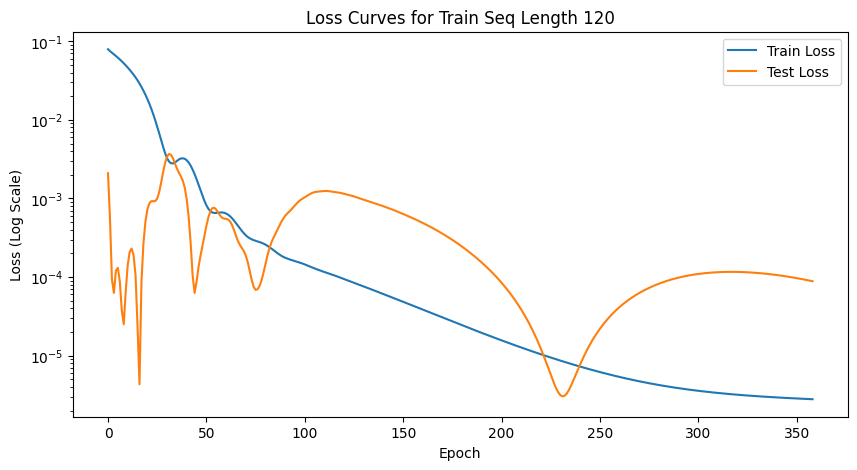

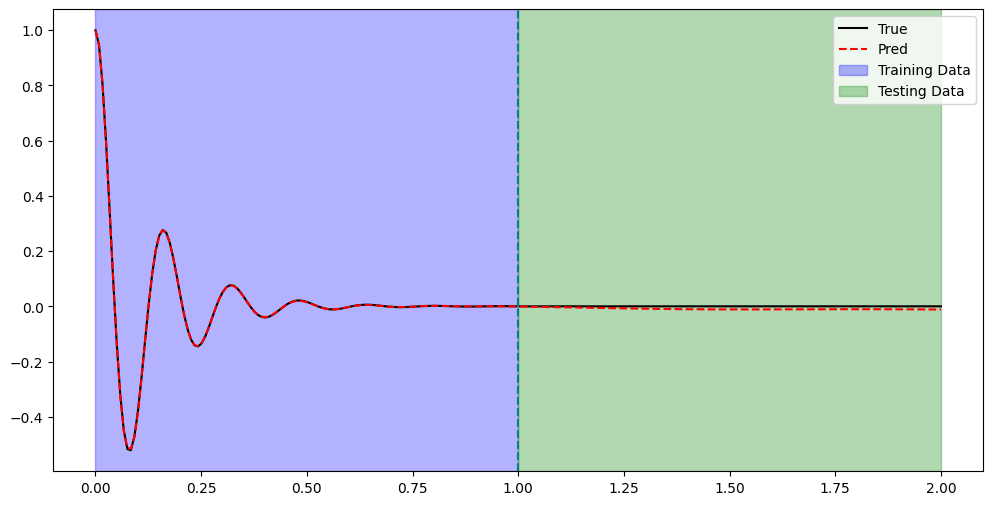

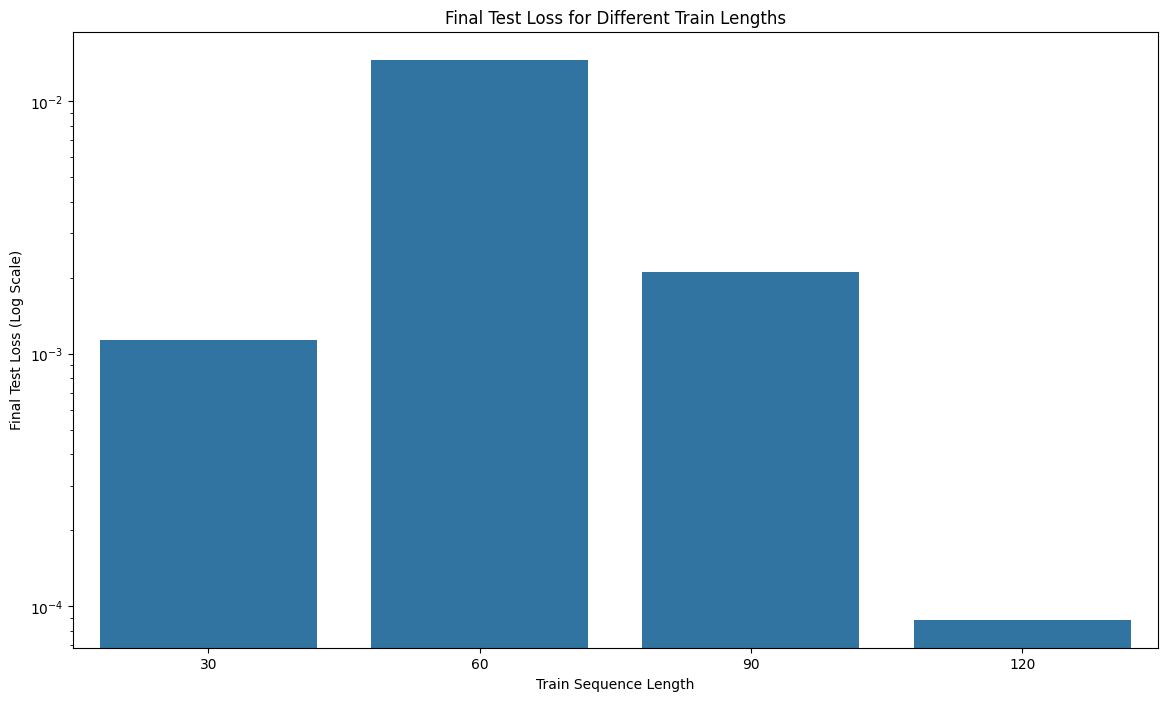

Train Seq Length 30:
  Final Train Loss: 8.858e-06
  Final Test Loss: 1.139e-03
Train Seq Length 60:
  Final Train Loss: 5.933e-06
  Final Test Loss: 1.462e-02
Train Seq Length 90:
  Final Train Loss: 5.243e-06
  Final Test Loss: 2.116e-03
Train Seq Length 120:
  Final Train Loss: 2.788e-06
  Final Test Loss: 8.847e-05


In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0, start_time=0):
    t = torch.linspace(start_time, start_time + seq_length//100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1).reshape(num_sequences, seq_length, 1)
    times = t.repeat(num_sequences, 1, 1).reshape(num_sequences, seq_length, 1)
    return sequences, times

# Plotting functions
def plot_loss_curves(train_losses, test_losses, train_seq_length):
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()




# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]
batch_size = 1
num_sequences = 1
total_seq_length = 240
train_seq_lengths = [30, 60, 90, 120]  # Different lengths of training sequences

convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100


d, w0 = 8, 40

# Initialize performance data dictionary
performance_data = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for train_seq_length in train_seq_lengths:

    test_seq_length = total_seq_length - train_seq_length
    
    model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    total_data, total_times = generate_oscillator_data(total_seq_length, num_sequences, d, w0, start_time=0)
    total_data, total_times = total_data.to(device), total_times.to(device)
    
    # Split into train and test sets by non-overlapping time intervals
    train_data = total_data[:, :train_seq_length, :]
    train_times = total_times[:, :train_seq_length, :]
    test_data = total_data[:, train_seq_length:, :]
    test_times = total_times[:, train_seq_length:, :]
    

    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        # state = train_data[:, :train_seq_length-1, :]  # Training part of the sequence
        
        # input = train_data[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        # input = train_times[:, 1:train_seq_length, :]  # Training part of the sequence (next state)
        state = train_data # Training part of the sequence
        input = train_times  # Training part of the sequence (next state)
        observation_target = train_data
        # observation_target = train_data[:, 1:train_seq_length, :]  # Target is the next value
        
        state = state.reshape(-1, state_dim)
        input = input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        next_state, observation = model(state, input)
        loss = criterion(next_state, state) + criterion(observation, observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            # test_state = test_data[:, :train_seq_length-1, :]
            # test_input = test_times[:, 1:train_seq_length, :]

            test_state = test_data
            test_input = test_times
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            test_loss = criterion(test_observation, test_data.reshape(-1, output_dim))
            test_losses.append(test_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_seq_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1]
    })
    
    # Plot loss curves
    plot_loss_curves(train_losses, test_losses, train_seq_length)

    
    plt.figure(figsize=(12, 6))
    trn_time_plt = train_times.reshape(-1, 1).cpu().numpy()
    tst_time_plt = test_times.reshape(-1, 1).cpu().numpy()

    trn_true_plt = train_data.reshape(-1, 1).cpu().numpy()
    tst_true_plt = test_data.reshape(-1, 1).cpu().numpy()

    trn_pred_plt = observation.reshape(-1, 1).detach().cpu().numpy()
    tst_pred_plt = test_observation.reshape(-1, 1).detach().cpu().numpy()

    vline = (trn_time_plt[-1]+tst_time_plt[0])/2

    plt.plot(trn_time_plt, trn_true_plt, color='black', linestyle='-', label="True")
    plt.plot(tst_time_plt, tst_true_plt, color='black', linestyle='-')

    plt.plot(trn_time_plt, trn_pred_plt, color='red', linestyle='--', label="Pred")
    plt.plot(tst_time_plt, tst_pred_plt, color='red', linestyle='--')

    plt.axvspan(0, vline[0], alpha=0.3, color='blue', label="Training Data")
    plt.axvspan(vline[0], tst_time_plt[-1][0], alpha=0.3, color='green', label="Testing Data")
    plt.axvline(vline, color='teal', linestyle='--')

    plt.legend()
    plt.show()

# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_test_loss", data=performance_df)
plt.title("Final Test Loss for Different Train Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Test Loss (Log Scale)")
plt.show()




# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


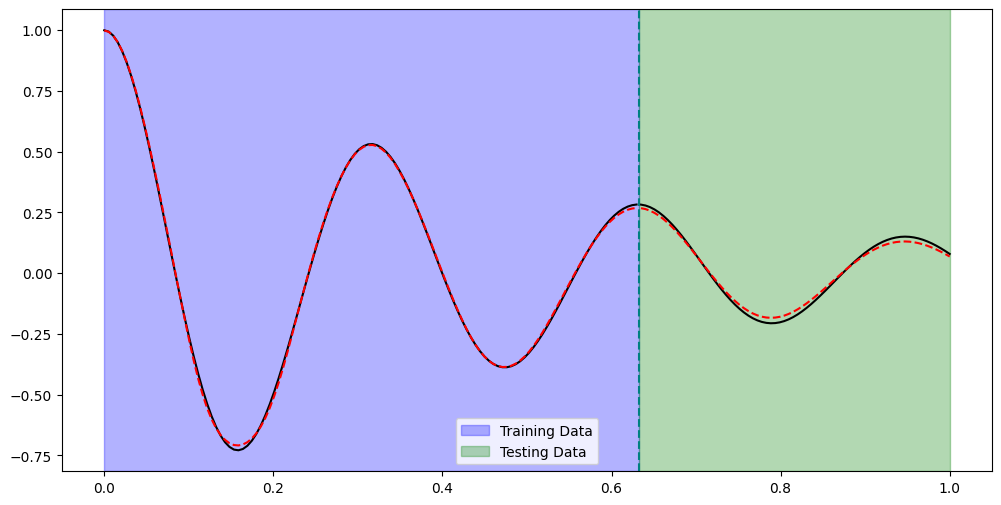

In [132]:
plt.figure(figsize=(12, 6))
trn_time_plt = train_times.reshape(-1, 1).cpu().numpy()
tst_time_plt = test_times.reshape(-1, 1).cpu().numpy()

trn_true_plt = train_data.reshape(-1, 1).cpu().numpy()
tst_true_plt = test_data.reshape(-1, 1).cpu().numpy()

trn_pred_plt = observation.reshape(-1, 1).detach().cpu().numpy()
tst_pred_plt = test_observation.reshape(-1, 1).detach().cpu().numpy()

vline = (trn_time_plt[-1]+tst_time_plt[0])/2

plt.plot(trn_time_plt, trn_true_plt, color='black', linestyle='-')
plt.plot(tst_time_plt, tst_true_plt, color='black', linestyle='-')

plt.plot(trn_time_plt, trn_pred_plt, color='red', linestyle='--')
plt.plot(tst_time_plt, tst_pred_plt, color='red', linestyle='--')

plt.axvspan(0, vline[0], alpha=0.3, color='blue', label="Training Data")
plt.axvspan(vline[0], tst_time_plt[-1][0], alpha=0.3, color='green', label="Testing Data")
plt.axvline(vline, color='teal', linestyle='--')

plt.legend()
plt.show()

In [128]:
vline

array([0.6322751], dtype=float32)

In [125]:
trn_time_plt[-1][0]

0.6296296

In [99]:
train_data.shape, train_times.shape, test_data.shape, test_times.shape, observation.shape, test_observation.shape

(torch.Size([1, 30, 1]),
 torch.Size([1, 30, 1]),
 torch.Size([1, 90, 1]),
 torch.Size([1, 90, 1]),
 torch.Size([29, 1]),
 torch.Size([29, 1]))

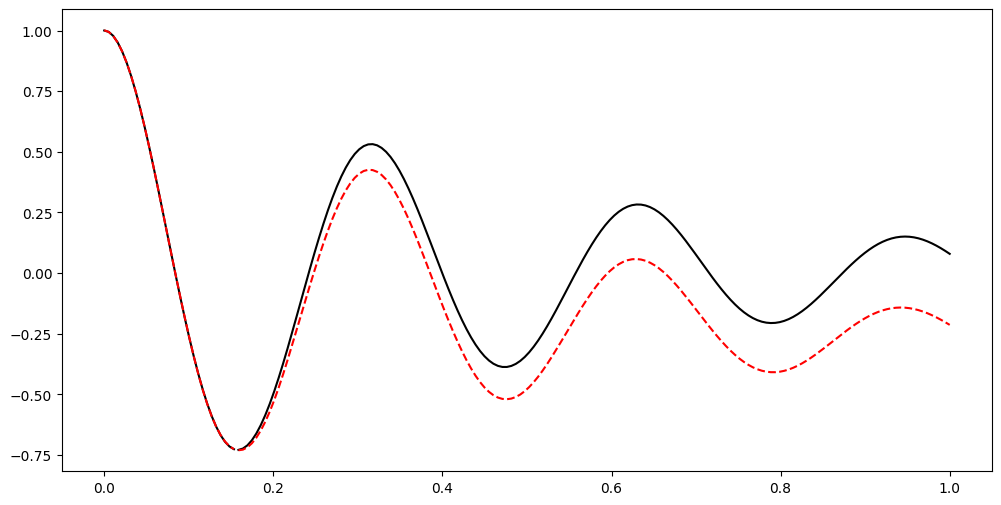

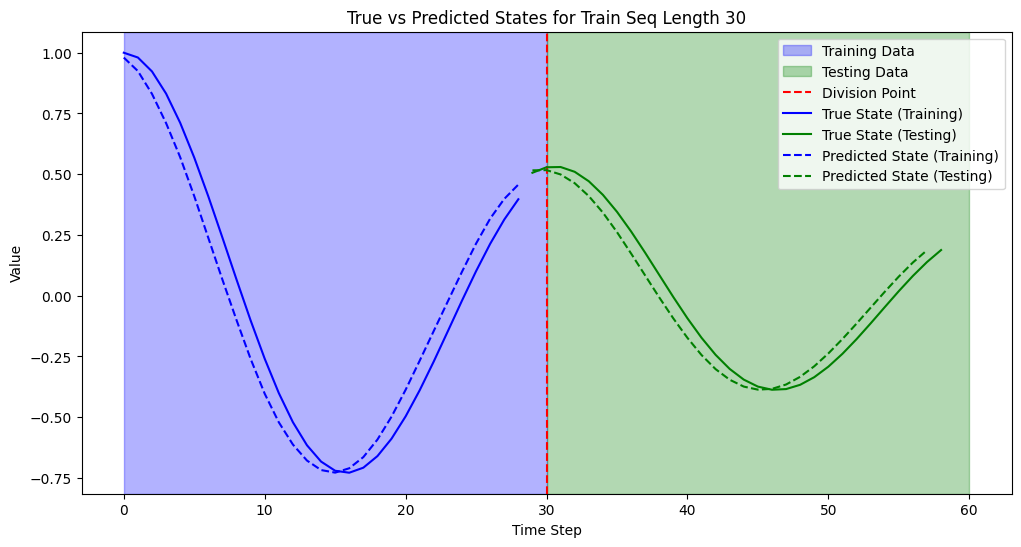

In [83]:
def plot_true_vs_predicted(train_seq_length, total_seq_length, exemplar_state, exemplar_test, pred_train_state, pred_test_state):
    plt.figure(figsize=(12, 6))
    plt.axvspan(0, train_seq_length, alpha=0.3, color='blue', label="Training Data")
    plt.axvspan(train_seq_length, train_seq_length * 2, alpha=0.3, color='green', label="Testing Data")
    plt.axvline(train_seq_length, color='red', linestyle='--', label="Division Point")
    
    # Plot true states
    plt.plot(range(train_seq_length - 1), exemplar_state, label="True State (Training)", color='blue')
    plt.plot(range(train_seq_length - 1, train_seq_length * 2 - 1), exemplar_test, label="True State (Testing)", color='green')
    
    # Plot predicted states
    plt.plot(range(train_seq_length - 1), pred_train_state, label="Predicted State (Training)", color='blue', linestyle='--')
    plt.plot(range(train_seq_length - 1, train_seq_length * 2 - 2), pred_test_state, label="Predicted State (Testing)", color='green', linestyle='--')
    
    plt.title(f"True vs Predicted States for Train Seq Length {train_seq_length}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
# Generate exemplar data for the plot
exemplar_index = 0
exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
exemplar_test = test_data[exemplar_index, :train_seq_length, :].squeeze().cpu().numpy()



# Predict states for the exemplar
model.eval()
with torch.no_grad():
    # Predict for training data
    train_state = train_data[exemplar_index, :train_seq_length-1, :].reshape(-1, state_dim)
    train_input = train_data[exemplar_index, 1:train_seq_length, :].reshape(-1, input_dim)
    _, pred_train_state = model(train_state.to(device), train_input.to(device))
    pred_train_state = pred_train_state.cpu().numpy().reshape(-1)
    
    # Predict for testing data
    test_state = test_data[exemplar_index, :train_seq_length-1, :].reshape(-1, state_dim)
    test_input = test_data[exemplar_index, 1:train_seq_length, :].reshape(-1, input_dim)
    _, pred_test_state = model(test_state.to(device), test_input.to(device))
    pred_test_state = pred_test_state.cpu().numpy().reshape(-1)

# Plot true vs predicted states
plot_true_vs_predicted(train_seq_length, total_seq_length, exemplar_state, exemplar_test, pred_train_state, pred_test_state)


ValueError: x and y must have same first dimension, but have shapes (30,) and torch.Size([290, 1])

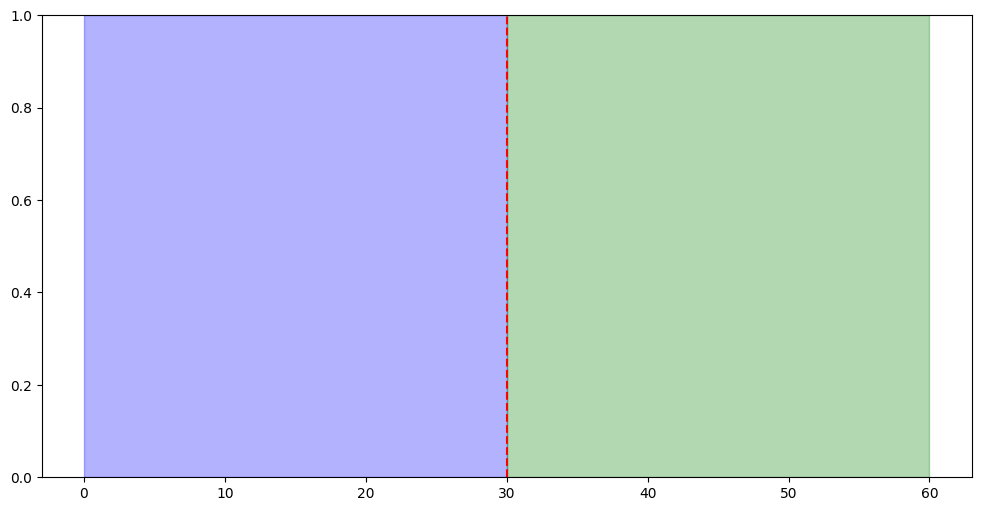

In [54]:
# Plot data division
plot_data_division(train_seq_length, test_state, test_observation)

Train Seq Length 10, Extrapolation Length 110, Epoch 10, Train Loss: 7.534e-01, Test Loss: 3.332e-01, Extrapolation Loss: 2.338e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 20, Train Loss: 6.623e-01, Test Loss: 2.996e-01, Extrapolation Loss: 2.280e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 30, Train Loss: 5.545e-01, Test Loss: 2.541e-01, Extrapolation Loss: 2.231e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 40, Train Loss: 4.222e-01, Test Loss: 1.922e-01, Extrapolation Loss: 2.285e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 50, Train Loss: 2.702e-01, Test Loss: 1.175e-01, Extrapolation Loss: 2.774e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 60, Train Loss: 1.261e-01, Test Loss: 4.749e-02, Extrapolation Loss: 4.427e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 70, Train Loss: 3.606e-02, Test Loss: 9.687e-03, Extrapolation Loss: 7.746e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 80, Train Loss: 1.614e-

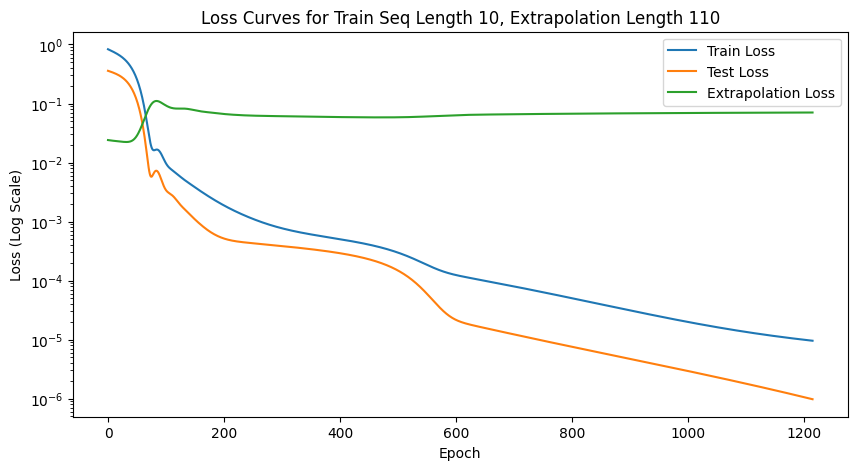

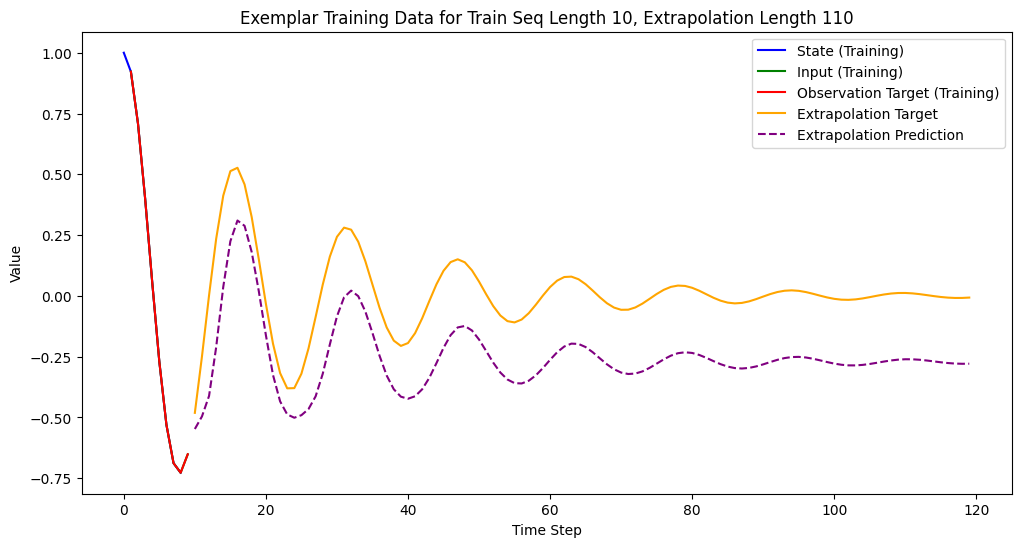

Train Seq Length 15, Extrapolation Length 105, Epoch 10, Train Loss: 5.589e-01, Test Loss: 2.442e-01, Extrapolation Loss: 1.833e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 20, Train Loss: 4.920e-01, Test Loss: 2.118e-01, Extrapolation Loss: 1.620e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 30, Train Loss: 4.085e-01, Test Loss: 1.708e-01, Extrapolation Loss: 1.334e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 40, Train Loss: 3.031e-01, Test Loss: 1.192e-01, Extrapolation Loss: 9.343e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 50, Train Loss: 1.846e-01, Test Loss: 6.431e-02, Extrapolation Loss: 5.379e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 60, Train Loss: 8.495e-02, Test Loss: 2.562e-02, Extrapolation Loss: 4.752e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 70, Train Loss: 3.970e-02, Test Loss: 1.602e-02, Extrapolation Loss: 9.108e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 80, Train Loss: 3.204e-

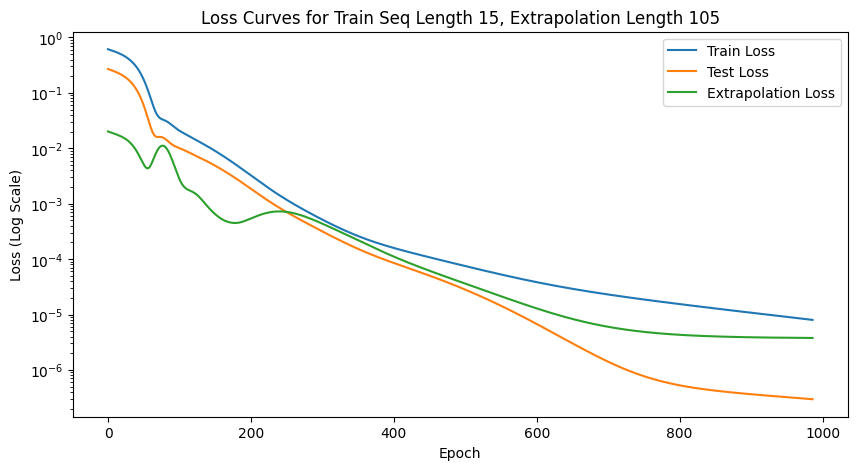

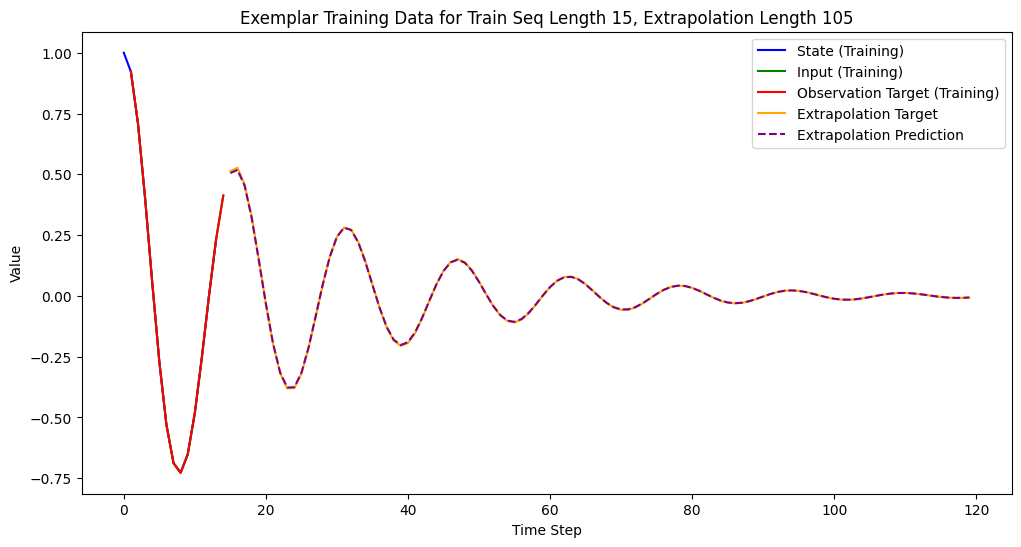

Train Seq Length 30, Extrapolation Length 90, Epoch 10, Train Loss: 3.551e-01, Test Loss: 1.662e-01, Extrapolation Loss: 6.421e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 20, Train Loss: 3.148e-01, Test Loss: 1.450e-01, Extrapolation Loss: 5.674e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 30, Train Loss: 2.615e-01, Test Loss: 1.181e-01, Extrapolation Loss: 4.657e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 40, Train Loss: 1.911e-01, Test Loss: 8.405e-02, Extrapolation Loss: 3.354e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 50, Train Loss: 1.099e-01, Test Loss: 4.696e-02, Extrapolation Loss: 2.087e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 60, Train Loss: 4.367e-02, Test Loss: 2.010e-02, Extrapolation Loss: 1.720e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 70, Train Loss: 2.104e-02, Test Loss: 1.350e-02, Extrapolation Loss: 2.241e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 80, Train Loss: 2.094e-02, Test

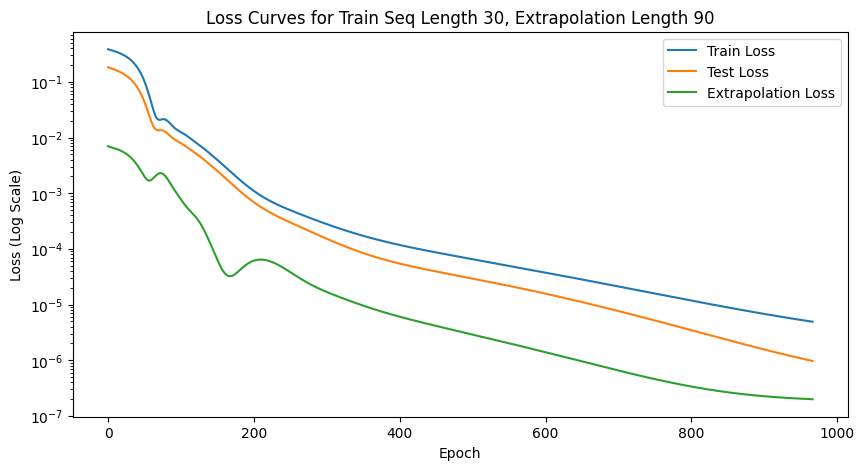

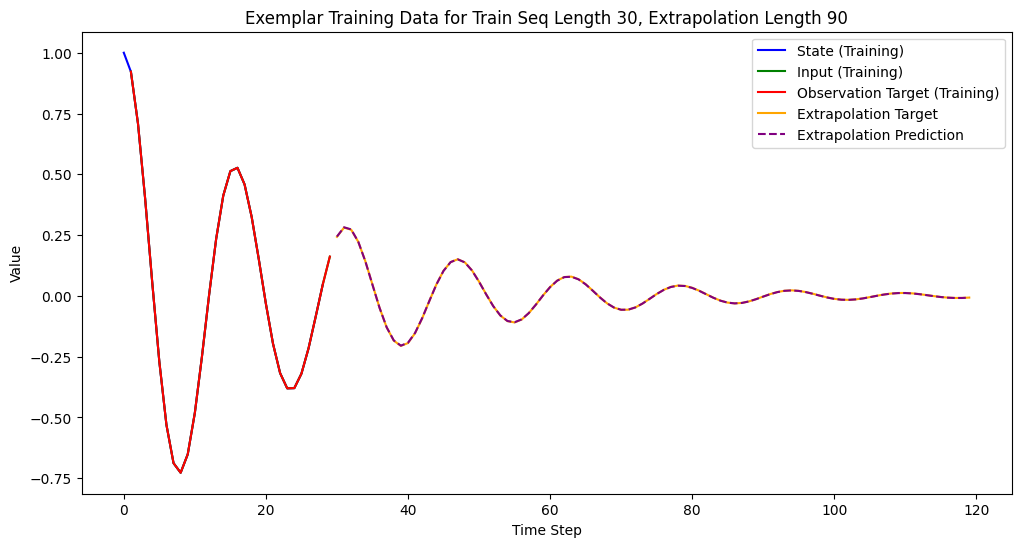

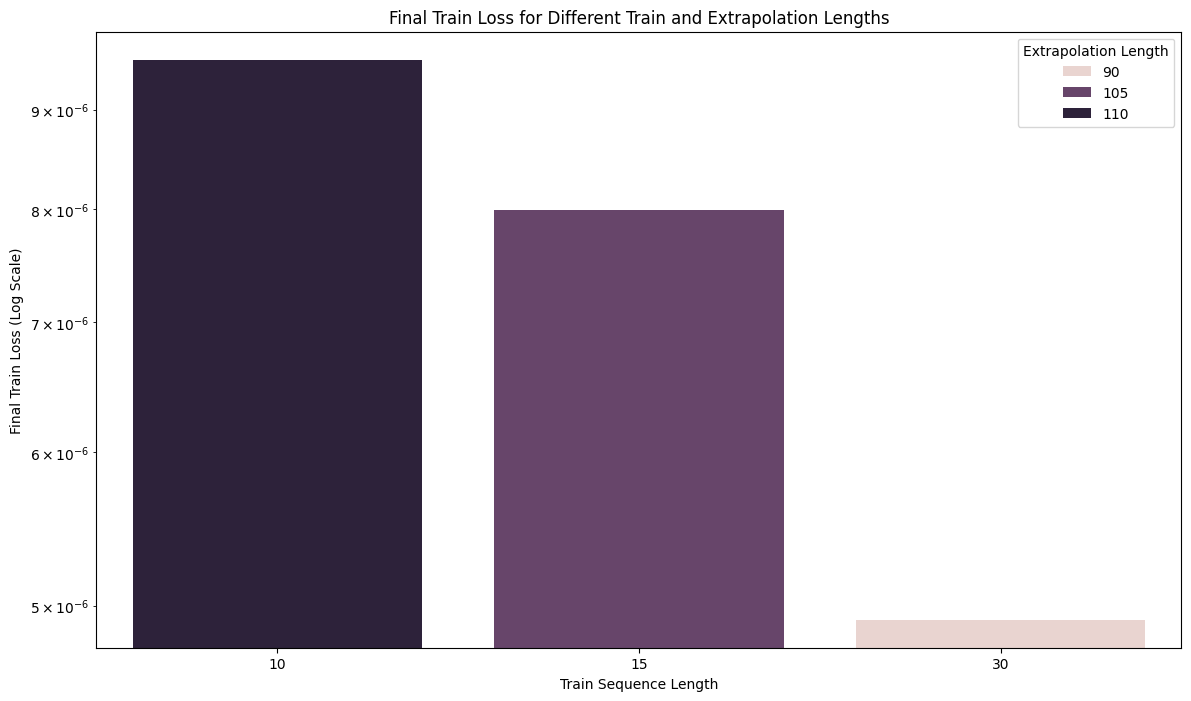

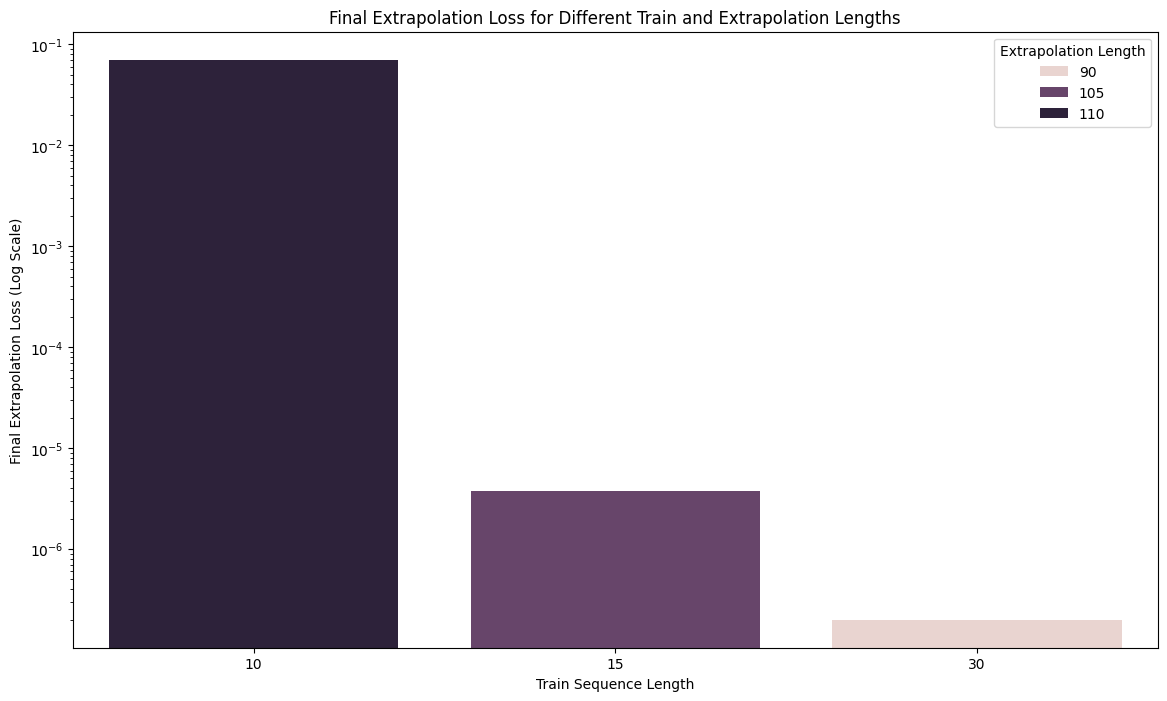

Train Seq Length 10, Extrapolation Length 110:
  Final Train Loss: 9.553e-06
  Final Test Loss: 9.750e-07
  Final Extrapolation Loss: 7.039e-02
Train Seq Length 15, Extrapolation Length 105:
  Final Train Loss: 7.998e-06
  Final Test Loss: 2.959e-07
  Final Extrapolation Loss: 3.775e-06
Train Seq Length 30, Extrapolation Length 90:
  Final Train Loss: 4.920e-06
  Final Test Loss: 9.708e-07
  Final Extrapolation Loss: 1.995e-07


NameError: name 'json' is not defined

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length / 100, seq_length)
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times


def train(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    performance_data = []

    for train_seq_length in config['train_seq_lengths']:
        extrapolation_length = config['total_seq_length'] - train_seq_length
        
        model = StateSpaceModel(config['state_dim'], config['input_dim'], config['output_dim'], config['kan_layers']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.MSELoss()
        
        train_data, train_times = generate_oscillator_data(config['total_seq_length'], config['num_sequences'], config['d'], config['w0'])
        train_data, train_times = train_data.to(device), train_times.to(device)
        
        train_losses = []
        test_losses = []
        patience_counter = 0
        
        epoch = 0
        while patience_counter < config['patience']:
            model.train()
            optimizer.zero_grad()
            
            state = train_data[:, :train_seq_length-1, :]
            input = train_data[:, 1:train_seq_length, :]
            observation_target = train_data[:, 1:train_seq_length, :]
            
            state = state.reshape(-1, config['state_dim'])
            input = input.reshape(-1, config['input_dim'])
            observation_target = observation_target.reshape(-1, config['output_dim'])
            
            next_state, observation = model(state, input)
            loss = criterion(next_state, state) + criterion(observation, observation_target)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

            if len(train_losses) > config['n_pts']:
                recent_losses = train_losses[-config['n_pts']:]
                std_recent_losses = np.std(recent_losses)
                if std_recent_losses < config['convergence_std_threshold']:
                    patience_counter += 1
                else:
                    patience_counter = 0
            else:
                patience_counter = 0
            
            model.eval()
            with torch.no_grad():
                test_state = train_data[:, :train_seq_length-1, :]
                test_input = train_data[:, 1:train_seq_length, :]
                
                test_state = test_state.reshape(-1, config['state_dim'])
                test_input = test_input.reshape(-1, config['input_dim'])
                
                _, test_observation = model(test_state, test_input)
                
                extrap_state = train_data[:, train_seq_length-1:-1, :]
                extrap_input = train_data[:, train_seq_length:, :]
                extrap_target = train_data[:, train_seq_length:, :]
                
                extrap_state = extrap_state.reshape(-1, config['state_dim'])
                extrap_input = extrap_input.reshape(-1, config['input_dim'])
                extrap_target = extrap_target.reshape(-1, config['output_dim'])
                
                _, extrap_observation = model(extrap_state, extrap_input)
                
                test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, config['output_dim']))
                extrapolation_loss = criterion(extrap_observation, extrap_target)
                test_losses.append((test_loss.item(), extrapolation_loss.item()))

            if (epoch + 1) % config['log_interval'] == 0:
                print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
            
            epoch += 1
        
        performance_data.append({
            "train_seq_length": train_seq_length,
            "extrapolation_length": extrapolation_length,
            "final_train_loss": train_losses[-1],
            "final_test_loss": test_losses[-1][0],
            "final_extrapolation_loss": test_losses[-1][1]
        })
        
        train_losses = np.array(train_losses)
        test_losses = np.array(test_losses)
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses[:, 0], label="Test Loss")
        plt.plot(test_losses[:, 1], label="Extrapolation Loss")
        plt.yscale('log')
        plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (Log Scale)")
        plt.legend()
        plt.show()
        
        exemplar_index = 0
        exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
        exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
        exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
        exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

        model.eval()
        with torch.no_grad():
            extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
            extrap_input = train_data[exemplar_index, train_seq_length:, :]
            
            extrap_state = extrap_state.reshape(-1, config['state_dim'])
            extrap_input = extrap_input.reshape(-1, config['input_dim'])
            
            _, extrap_prediction = model(extrap_state, extrap_input)
            extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

        plt.figure(figsize=(12, 6))
        plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
        plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
        plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
        plt.plot(range(train_seq_length, config['total_seq_length']), exemplar_extrapolation, label="Extrapolation Target", color='orange')
        plt.plot(range(train_seq_length, config['total_seq_length']), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
        plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    
    performance_df = pd.DataFrame(performance_data)

    plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
    plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Train Loss (Log Scale)")
    plt.legend(title="Extrapolation Length")
    plt.show()

    plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
    plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Extrapolation Loss (Log Scale)")
    plt.legend(title="Extrapolation Length")
    plt.show()

    for data in performance_data:
        print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
        print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
        print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
        print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

    with open(config['performance_data_file'], "w") as f:
        json.dump(performance_data, f)

config = {
    'state_dim': 1,
    'input_dim': 1,
    'output_dim': 1,
    'kan_layers': [16, 16],
    'batch_size': 10,
    'num_sequences': 10,
    'total_seq_length': 120,
    'train_seq_lengths': [10, 15, 30],
    'convergence_std_threshold': 1e-6,
    'patience': 13,
    'n_pts': 100,
    'd': 4,
    'w0': 40,
    'learning_rate': 1e-3,
    'log_interval': 10,
    'performance_data_file': "performance_data.json"
}

train(config)


In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import time
import json

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

def generate_oscillator_data(seq_length, num_sequences, d, w0, noise_std=0.0):
    t = torch.linspace(0, seq_length / 100, seq_length)
    data = oscillator(d, w0, t).unsqueeze(-1)
    if noise_std > 0:
        noise = noise_std * torch.randn_like(data)
        data += noise
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

def create_experiment_directory(base_path="experiments"):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    run_timestamp = str(int(time.time()))
    run_directory = os.path.join(base_path, run_timestamp)
    os.makedirs(run_directory)
    return run_directory

def save_figure(fig, filepath):
    fig.savefig(filepath, bbox_inches='tight')
    plt.close(fig)

def train(config):
    run_directory = create_experiment_directory()
    
    # Save config to the run directory
    with open(os.path.join(run_directory, "config.json"), "w") as config_file:
        json.dump(config, config_file, indent=4)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    performance_data = []

    for train_seq_length in config['train_seq_lengths']:
        validation_length = (config['total_seq_length'] - train_seq_length) // 2
        test_length = config['total_seq_length'] - train_seq_length - validation_length
        
        model = StateSpaceModel(config['state_dim'], config['input_dim'], config['output_dim'], config['kan_layers']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.MSELoss()
        
        # # Generate noisy training data
        # train_data, _ = generate_oscillator_data(train_seq_length, config['num_sequences'], config['d'], config['w0'], noise_std=config['noise_std'])
        # train_data = train_data.to(device)

        # Generate validation data (no noise)
        val_data, _ = generate_oscillator_data(validation_length, config['num_sequences'], config['d'], config['w0'])
        val_data = val_data.to(device)

        # Generate test data (no noise)
        test_data, _ = generate_oscillator_data(test_length, config['num_sequences'], config['d'], config['w0'])
        test_data = test_data.to(device)
        
        train_losses = []
        val_losses = []
        
        epoch = 0
        patience_counter = 0
        while patience_counter < config['patience']:
            model.train()
            optimizer.zero_grad()

            # Generate noisy training data
            train_data, _ = generate_oscillator_data(train_seq_length, config['num_sequences'], config['d'], config['w0'], noise_std=config['noise_std'])
            train_data = train_data.to(device)
            
            state = train_data[:, :train_seq_length-1, :]
            input = train_data[:, 1:train_seq_length, :]
            observation_target = train_data[:, 1:train_seq_length, :]
            
            state = state.reshape(-1, config['state_dim'])
            input = input.reshape(-1, config['input_dim'])
            observation_target = observation_target.reshape(-1, config['output_dim'])
            
            next_state, observation = model(state, input)
            loss = criterion(next_state, state) + criterion(observation, observation_target)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

            if len(train_losses) > config['n_pts']:
                recent_losses = train_losses[-config['n_pts']:]
                std_recent_losses = np.std(recent_losses)
                if std_recent_losses < config['convergence_std_threshold']:
                    patience_counter += 1
                else:
                    patience_counter = 0
            
            model.eval()
            with torch.no_grad():
                val_state = val_data[:, :validation_length-1, :]
                val_input = val_data[:, 1:validation_length, :]
                
                val_state = val_state.reshape(-1, config['state_dim'])
                val_input = val_input.reshape(-1, config['input_dim'])
                
                _, val_observation = model(val_state, val_input)
                val_loss = criterion(val_observation, val_data[:, 1:validation_length, :].reshape(-1, config['output_dim']))
                val_losses.append(val_loss.item())

            if (epoch + 1) % config['log_interval'] == 0:
                print(f"Train Seq Length {train_seq_length}, Validation Length {validation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Val Loss: {val_loss.item():.3e}")
            
            epoch += 1
        
        # Generate final test data
        model.eval()
        with torch.no_grad():
            test_state = test_data[:, :test_length-1, :]
            test_input = test_data[:, 1:test_length, :]
            
            test_state = test_state.reshape(-1, config['state_dim'])
            test_input = test_input.reshape(-1, config['input_dim'])
            
            _, test_observation = model(test_state, test_input)
            test_loss = criterion(test_observation, test_data[:, 1:test_length, :].reshape(-1, config['output_dim']))
        
        performance_data.append({
            "train_seq_length": train_seq_length,
            "validation_length": validation_length,
            "test_length": test_length,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "final_test_loss": test_loss.item()
        })
        
        train_losses = np.array(train_losses)
        val_losses = np.array(val_losses)
        
        fig = plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.yscale('log')
        plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Validation Length {validation_length}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (Log Scale)")
        plt.legend()
        save_figure(fig, os.path.join(run_directory, f"loss_curves_{train_seq_length}.png"))
    
    performance_df = pd.DataFrame(performance_data)

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_train_loss", hue="validation_length", data=performance_df)
    plt.title("Final Train Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Train Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_train_loss.png"))

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_val_loss", hue="validation_length", data=performance_df)
    plt.title("Final Validation Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Validation Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_val_loss.png"))

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_test_loss", hue="validation_length", data=performance_df)
    plt.title("Final Test Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Test Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_test_loss.png"))

    performance_df.to_csv(os.path.join(run_directory, "performance_data.csv"), index=False)

    with open(os.path.join(run_directory, "performance_data.json"), "w") as f:
        json.dump(performance_data, f)

    # Within the train function, after model evaluation and performance data logging

    # Plot exemplar data for training, validation, and test sets
    exemplar_index = 0

    # Extract data for plotting
    train_example = train_data[exemplar_index, :train_seq_length, :].squeeze().cpu().numpy()
    val_example = val_data[exemplar_index, :validation_length, :].squeeze().cpu().numpy()
    test_example = test_data[exemplar_index, :test_length, :].squeeze().cpu().numpy()

    # Generate time axes for each segment
    train_time = np.linspace(0, train_seq_length / 100, train_seq_length)
    val_time = np.linspace(train_seq_length / 100, (train_seq_length + validation_length) / 100, validation_length)
    test_time = np.linspace((train_seq_length + validation_length) / 100, config['total_seq_length'] / 100, test_length)

    # Combine all sequences and time axes for plotting
    combined_example = np.concatenate((train_example, val_example, test_example), axis=0)
    combined_time = np.concatenate((train_time, val_time, test_time))

    # Model predictions for the entire sequence (training, validation, and test)
    model.eval()
    with torch.no_grad():
        combined_state = torch.cat([train_data[exemplar_index, :train_seq_length-1, :],
                                    val_data[exemplar_index, :validation_length-1, :],
                                    test_data[exemplar_index, :test_length-1, :]], dim=0)
        combined_input = torch.cat([train_data[exemplar_index, 1:train_seq_length, :],
                                    val_data[exemplar_index, 1:validation_length, :],
                                    test_data[exemplar_index, 1:test_length, :]], dim=0)

        combined_state = combined_state.reshape(-1, config['state_dim']).to(device)
        combined_input = combined_input.reshape(-1, config['input_dim']).to(device)
        
        _, combined_prediction = model(combined_state, combined_input)
        combined_prediction = combined_prediction.cpu().numpy().reshape(-1)

    # Adjust combined time axis for predictions (one step ahead)
    combined_time_predictions = np.concatenate((train_time[1:], val_time[1:], test_time[1:]))

    # Plotting the combined data
    fig = plt.figure(figsize=(12, 6))
    plt.plot(combined_time, combined_example, label="True Data", color='blue')
    plt.plot(combined_time_predictions, combined_prediction, label="Model Prediction", color='red', linestyle='--')
    plt.axvline(x=train_seq_length / 100, color='green', linestyle=':', label='End of Training')
    plt.axvline(x=(train_seq_length + validation_length) / 100, color='orange', linestyle=':', label='End of Validation')
    plt.title(f"Training, Validation, and Test Data with Model Prediction")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    save_figure(fig, os.path.join(run_directory, "combined_data_plot.png"))



config = {
    'state_dim': 1,
    'input_dim': 1,
    'output_dim': 1,
    'kan_layers': [16, 16],
    'batch_size': 10,
    'num_sequences': 10,
    'total_seq_length': 120,
    'train_seq_lengths': [10, 15],
    'convergence_std_threshold': 1e-3,
    'patience': 13,
    'n_pts': 100,
    'd': 4,
    'w0': 40,
    'learning_rate': 1e-3,
    'log_interval': 10,
    'noise_std': 0.1  # Standard deviation of noise for training data
}

train(config)


Train Seq Length 10, Validation Length 55, Epoch 10, Train Loss: 7.613e-01, Val Loss: 9.659e-02
Train Seq Length 10, Validation Length 55, Epoch 20, Train Loss: 4.771e-01, Val Loss: 8.832e-02
Train Seq Length 10, Validation Length 55, Epoch 30, Train Loss: 5.999e-01, Val Loss: 7.813e-02
Train Seq Length 10, Validation Length 55, Epoch 40, Train Loss: 3.824e-01, Val Loss: 6.689e-02
Train Seq Length 10, Validation Length 55, Epoch 50, Train Loss: 2.869e-01, Val Loss: 5.582e-02
Train Seq Length 10, Validation Length 55, Epoch 60, Train Loss: 1.750e-01, Val Loss: 4.717e-02
Train Seq Length 10, Validation Length 55, Epoch 70, Train Loss: 4.374e-02, Val Loss: 4.415e-02
Train Seq Length 10, Validation Length 55, Epoch 80, Train Loss: 3.989e-02, Val Loss: 4.755e-02
Train Seq Length 10, Validation Length 55, Epoch 90, Train Loss: 2.109e-02, Val Loss: 4.510e-02
Train Seq Length 10, Validation Length 55, Epoch 100, Train Loss: 1.852e-02, Val Loss: 3.979e-02
Train Seq Length 10, Validation Length 